# いろんなモデルを作ってアンサンブルする

In [1]:
import tensorflow
from tensorflow import keras

import matplotlib as mpl

import seaborn as sns
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import math
import scipy as sp
sns.set()


import requests,zipfile
import io
from io import StringIO

import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%precision 3

np.random.seed(0)
import scipy.stats as st
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

scaler = StandardScaler()
#features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
#features = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
features = ['Age*Pclass', 'Sex',  'FamilySize', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt


In [4]:
#バッチサイズ　1回に取り出すデータ数
#エポック数　トレーニングのセット数
#過剰適合ならエポック数を減らし、未収束ならエポック数を増やす
batch_size=128
num_class =10
epochs =20


In [5]:
#モデル評価用

model_score=pd.DataFrame([],columns=['model', 'score'])

# ここから先cross varidationの練習

In [6]:
from sklearn.model_selection import StratifiedKFold

In [7]:
cv_train_data=pd.read_csv('train.csv',sep=',')
cv_test_data=pd.read_csv('test.csv',sep=',')
cv_train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


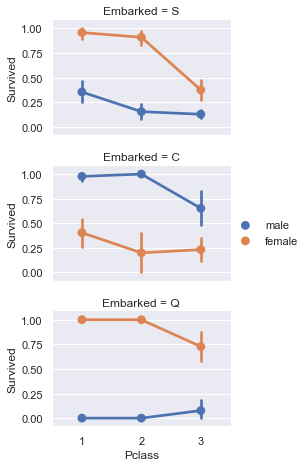

In [8]:
#性別と乗った港、クラスによって生存率がかわるか。

# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(cv_train_data, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


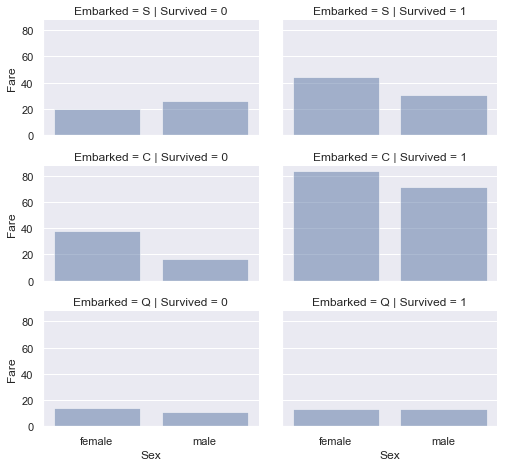

In [9]:
grid = sns.FacetGrid(cv_train_data, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

In [10]:
age_mean=cv_train_data['Age'].mean()
fare_mean=cv_train_data['Fare'].mean()

# Ageとfareについて、EmbarkedとPclassごとの平均と標準偏差をとって、それで定義することにする

In [11]:
guess_ages = np.zeros((2,3))
guess_fares = np.zeros((2,3))
cv_test_data=cv_test_data.replace('male',0)
cv_test_data=cv_test_data.replace('female',1)
cv_train_data=cv_train_data.replace('male',0)
cv_train_data=cv_train_data.replace('female',1)

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = cv_train_data[(cv_train_data['Sex'] == i) & (cv_train_data['Pclass'] == j+1)]['Age'].dropna()
        guess_df_fare = cv_train_data[(cv_train_data['Sex'] == i) & (cv_train_data['Pclass'] == j+1)]['Fare'].dropna()
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        age_guess = guess_df.median()
        fare_guess=guess_df_fare.median()
        print(age_guess,fare_guess)
        guess_ages[i,j]=age_guess
        guess_fares[i,j]=fare_guess
            
for i in range(0, 2):
    for j in range(0, 3):
        cv_train_data.loc[ (cv_train_data.Age.isnull()) & (cv_train_data.Sex == i) & (cv_train_data.Pclass == j+1),'Age'] = guess_ages[i,j]
        cv_test_data.loc[ (cv_test_data.Age.isnull()) & (cv_test_data.Sex == i) & (cv_test_data.Pclass == j+1),'Age'] = guess_ages[i,j]
        
        cv_train_data.loc[ (cv_train_data.Fare.isnull()) & (cv_train_data.Sex == i) & (cv_train_data.Pclass == j+1),'Fare'] = guess_fares[i,j]
        cv_test_data.loc[ (cv_test_data.Fare.isnull()) & (cv_test_data.Sex == i) & (cv_test_data.Pclass == j+1),'Fare'] = guess_fares[i,j]
cv_train_data['Age'] = cv_train_data['Age'].astype(int)
cv_test_data['Age'] = cv_test_data['Age'].astype(int)
cv_train_data['Age'] = cv_train_data['Fare'].astype(int)
cv_test_data['Age'] = cv_test_data['Fare'].astype(int)

40.0 41.2625
30.0 13.0
25.0 7.925
35.0 82.66454999999999
28.0 22.0
21.5 12.475


In [12]:
#欠損を確認し、それをどうにかする
#fillna('値'):欠損値を値に上書き
#dropna():欠損値のある行を削除
#print(pd.isnull(train_data_x.iloc[:,:]))

#不要な説明変数を削除する
#Name:客の名前なので削除

if 'Name' in cv_train_data.columns:
    cv_train_data=cv_train_data.drop(columns=['Name'])
else:
    print('Name is not found in cv_train_data')
    


#Ticket:チケット番号を削除
if 'Ticket' in cv_train_data.columns:
    cv_train_data=cv_train_data.drop(columns=['Ticket'])
else:
    print('Ticket is not found in cv_train_data')
    

    

#Sexをmale=0,female=1に変換する
cv_train_data=cv_train_data.replace('male',0)
cv_train_data=cv_train_data.replace('female',1)


#Embarkedをダミー変数に変換する
cv_train_data=pd.concat([cv_train_data, pd.get_dummies(cv_train_data['Embarked'], prefix='Embarked')], axis=1)
if 'Embarked' in cv_train_data.columns:
    cv_train_data=cv_train_data.drop(columns=['Embarked'])


#Cabin 列が欠損が多いため削除する
if 'Cabin' in cv_train_data.columns:
    cv_train_data=cv_train_data.drop(columns=['Cabin'])
else:
    print('Cabin is not found in cv_train_data')
    
#SibSp 	Parchを削除すると精度ダウンした。
    
#SibSp 	ParchをまとめてFamilySizeにする

if 'FamilySize' not in cv_train_data.columns:
    cv_train_data['FamilySize']=cv_train_data['SibSp']+cv_train_data['Parch']

if 'SibSp' in cv_train_data.columns:
    cv_train_data=cv_train_data.drop(columns=['SibSp'])
    cv_train_data=cv_train_data.drop(columns=['Parch'])



In [13]:
#テストデータの処理
#欠損を確認し、それをどうにかする
#fillna('値'):欠損値を値に上書き
#dropna():欠損値のある行を削除
#print(pd.isnull(train_data_x.iloc[:,:]))

#不要な説明変数を削除する
#Name:客の名前なので削除

if 'Name' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['Name'])
else:
    print('Name is not found in cv_test_data')
    


#Ticket:チケット番号を削除
if 'Ticket' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['Ticket'])
else:
    print('Ticket is not found in cv_test_data')
    

    

#Sexをmale=0,female=1に変換する
cv_test_data=cv_test_data.replace('male',0)
cv_test_data=cv_test_data.replace('female',1)


#Embarkedをダミー変数に変換する
cv_test_data=pd.concat([cv_test_data, pd.get_dummies(cv_test_data['Embarked'], prefix='Embarked')], axis=1)
if 'Embarked' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['Embarked'])


#Cabin 列が欠損が多いため削除する
if 'Cabin' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['Cabin'])
else:
    print('Cabin is not found in cv_test_data')
    
#SibSp 	Parchを削除すると精度ダウンした。
    
#SibSp 	ParchをまとめてFamilySizeにする

if 'FamilySize' not in cv_test_data.columns:
    cv_test_data['FamilySize']=cv_test_data['SibSp']+cv_test_data['Parch']

if 'SibSp' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['SibSp'])
    cv_test_data=cv_test_data.drop(columns=['Parch'])

#とりあえず、Ageがカラの場合、平均値にする

cv_test_data['Age'] = cv_test_data['Age'].fillna(age_mean)
cv_test_data['Fare'] = cv_test_data['Fare'].fillna(fare_mean)

#PassengerIdを落とす
if 'PassengerId' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['PassengerId'])

In [14]:
#とりあえず、Ageがカラの場合、平均値にする
#上で乗船箇所とPclassと性別毎の平均値で作ったので不要。

#cv_train_data['Age'] = cv_train_data['Age'].fillna(age_mean)
#cv_train_data['Fare'] = cv_train_data['Fare'].fillna(fare_mean)

In [15]:
#とりあえず、Ageがカラの場合、平均値にする

#cv_test_data['Age'] = cv_test_data['Age'].fillna(age_mean)
#cv_test_data['Fare'] = cv_test_data['Fare'].fillna(fare_mean)

In [16]:
#相関係数チェック
cv_train_data.corr()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.012668,0.012658,-0.001205,-0.033606,0.022148,-0.040143
Survived,-0.005007,1.000000,-0.338481,0.543351,0.257482,0.257307,0.168240,0.003650,-0.155660,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.550553,-0.549500,-0.243292,0.221009,0.081720,0.065997
Sex,-0.042939,0.543351,-0.131900,1.000000,0.182331,0.182333,0.082853,0.074115,-0.125722,0.200988
Age,0.012668,0.257482,-0.550553,0.182331,1.000000,0.999979,0.269165,-0.118319,-0.165803,0.217052
Fare,0.012658,0.257307,-0.549500,0.182333,0.999979,1.000000,0.269335,-0.117216,-0.166603,0.217138
Embarked_C,-0.001205,0.168240,-0.243292,0.082853,0.269165,0.269335,1.000000,-0.148258,-0.778359,-0.046215
Embarked_Q,-0.033606,0.003650,0.221009,0.074115,-0.118319,-0.117216,-0.148258,1.000000,-0.496624,-0.058592
Embarked_S,0.022148,-0.155660,0.081720,-0.125722,-0.165803,-0.166603,-0.778359,-0.496624,1.000000,0.079977
FamilySize,-0.040143,0.016639,0.065997,0.200988,0.217052,0.217138,-0.046215,-0.058592,0.079977,1.000000


In [17]:
#参考資料に乗っている相関チェック
cv_train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [18]:
cv_train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
1,1,0.742038
0,0,0.188908


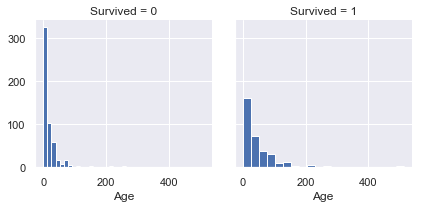

In [19]:
g = sns.FacetGrid(cv_train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#　→年齢を子供、大人、老人で分ける

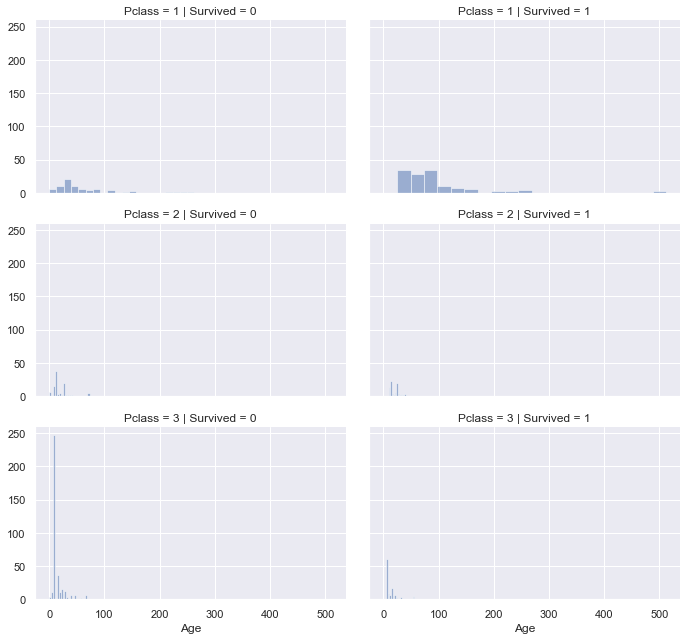

In [20]:
#年齢によってPclassごとの生存確率を確認
#子供は生存しやすい
#大人はPclass=1が生存しやすい
#→年齢を子供、大人、老人で分ける
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(cv_train_data, col='Survived', row='Pclass',  aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [21]:
cv_train_data.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age            0.257482
Fare           0.257307
Embarked_C     0.168240
Embarked_Q     0.003650
Embarked_S    -0.155660
FamilySize     0.016639
Name: Survived, dtype: float64

In [22]:
print('相関係数で高いものをチェック')
print('Pclass:\n',cv_train_data.corr()['Pclass'].drop('Pclass').max())
print('Sex:\n',cv_train_data.corr()['Sex'].drop('Sex').max())
print('Age:\n',cv_train_data.corr()['Age'].drop('Age').max())
print('Fare:\n',cv_train_data.corr()['Fare'].drop('Fare').max())
print('Embarked_C:\n',cv_train_data.corr()['Embarked_C'].drop('Embarked_C').max())
print('Embarked_Q:\n',cv_train_data.corr()['Embarked_Q'].drop('Embarked_Q').max())
print('Embarked_S:\n',cv_train_data.corr()['Embarked_S'].drop('Embarked_S').max())
print('FamilySize:\n',cv_train_data.corr()['FamilySize'].drop('FamilySize').max())

#sexが高かったので確認
cv_train_data.corr()['Sex']

相関係数で高いものをチェック
Pclass:
 0.221008919792132
Sex:
 0.5433513806577526
Age:
 0.9999791974608639
Fare:
 0.9999791974608639
Embarked_C:
 0.26933473491526394
Embarked_Q:
 0.221008919792132
Embarked_S:
 0.08172024174677404
FamilySize:
 0.21713840705243473


PassengerId   -0.042939
Survived       0.543351
Pclass        -0.131900
Sex            1.000000
Age            0.182331
Fare           0.182333
Embarked_C     0.082853
Embarked_Q     0.074115
Embarked_S    -0.125722
FamilySize     0.200988
Name: Sex, dtype: float64

In [23]:
#年齢をbindする
cv_train_data.loc[ cv_train_data['Age'] <= 16, 'Age'] = 0
cv_train_data.loc[(cv_train_data['Age'] > 16) & (cv_train_data['Age'] <= 32), 'Age'] = 1
cv_train_data.loc[(cv_train_data['Age'] > 32) & (cv_train_data['Age'] <= 48), 'Age'] = 2
cv_train_data.loc[(cv_train_data['Age'] > 48) & (cv_train_data['Age'] <= 64), 'Age'] = 3
cv_train_data.loc[ cv_train_data['Age'] > 64, 'Age']

1       71
27     263
31     146
34      82
52      76
61      80
62      83
72      73
88     263
102     77
118    247
120     73
124     77
139     79
151     66
159     69
180     69
195    146
201     69
215    113
218     76
224     90
230     83
245     90
256     79
257     86
258    512
262     79
268    153
269    135
      ... 
660    133
665     73
679    512
681     76
689    211
698    110
700    227
708    151
716    227
730    211
737    512
741     78
742    262
745     71
754     65
759     86
763    120
765     77
779    211
789     79
792     69
802    120
820     93
829     80
835     83
846     69
849     89
856    164
863     69
879     83
Name: Age, Length: 118, dtype: int64

In [24]:
#年齢をbindする
cv_test_data.loc[ cv_test_data['Age'] <= 16, 'Age'] = 0
cv_test_data.loc[(cv_test_data['Age'] > 16) & (cv_test_data['Age'] <= 32), 'Age'] = 1
cv_test_data.loc[(cv_test_data['Age'] > 32) & (cv_test_data['Age'] <= 48), 'Age'] = 2
cv_test_data.loc[(cv_test_data['Age'] > 48) & (cv_test_data['Age'] <= 64), 'Age'] = 3
cv_test_data.loc[ cv_test_data['Age'] > 64, 'Age']


12      82
24     262
48      76
53     263
59     262
64     262
69     263
74     211
75     211
81     221
96      78
114    221
118     75
141    151
142    262
150     83
156    221
179     83
181     83
184    247
188     69
196    134
202    227
212     73
217    164
218    211
230     65
234     71
236     75
239    106
242    134
252    136
270     75
272    136
287     82
293     81
306    151
308     93
314    135
316    146
324    211
327     79
342     69
343    512
352     73
353     65
360     69
365     69
371    134
374     81
375    262
385     65
390     93
397     79
400    164
407    211
411     90
414    108
Name: Age, dtype: int64

In [25]:
cv_train_data.corr()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.014097,0.012658,-0.001205,-0.033606,0.022148,-0.040143
Survived,-0.005007,1.000000,-0.338481,0.543351,0.223576,0.257307,0.168240,0.003650,-0.155660,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.467932,-0.549500,-0.243292,0.221009,0.081720,0.065997
Sex,-0.042939,0.543351,-0.131900,1.000000,0.169894,0.182333,0.082853,0.074115,-0.125722,0.200988
Age,0.014097,0.223576,-0.467932,0.169894,1.000000,0.969301,0.258043,-0.086488,-0.177180,0.151867
Fare,0.012658,0.257307,-0.549500,0.182333,0.969301,1.000000,0.269335,-0.117216,-0.166603,0.217138
Embarked_C,-0.001205,0.168240,-0.243292,0.082853,0.258043,0.269335,1.000000,-0.148258,-0.778359,-0.046215
Embarked_Q,-0.033606,0.003650,0.221009,0.074115,-0.086488,-0.117216,-0.148258,1.000000,-0.496624,-0.058592
Embarked_S,0.022148,-0.155660,0.081720,-0.125722,-0.177180,-0.166603,-0.778359,-0.496624,1.000000,0.079977
FamilySize,-0.040143,0.016639,0.065997,0.200988,0.151867,0.217138,-0.046215,-0.058592,0.079977,1.000000


In [26]:
cv_train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,1,0,3,0,0,7.2500,0,0,1,1
1,2,1,1,1,71,71.2833,1,0,0,1
2,3,1,3,1,0,7.9250,0,0,1,0
3,4,1,1,1,3,53.1000,0,0,1,1
4,5,0,3,0,0,8.0500,0,0,1,0


In [27]:
#Age*Pclassを特徴量として置く
if 'Age*Pclass' not in cv_train_data.columns:
    cv_train_data['Age*Pclass']=cv_train_data['Age']*cv_train_data['Pclass']
    
if 'Age*Pclass' not in cv_test_data.columns:
    cv_test_data['Age*Pclass']=cv_test_data['Age']*cv_test_data['Pclass']

if 'Age' in cv_train_data.columns:
    cv_train_data=cv_train_data.drop(columns=['Age'])
    cv_train_data=cv_train_data.drop(columns=['Pclass'])

if 'Age' in cv_test_data.columns:
    cv_test_data=cv_test_data.drop(columns=['Age'])
    cv_test_data=cv_test_data.drop(columns=['Pclass'])

In [28]:
cv_test_data.head()

,Sex,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Age*Pclass
0,0,7.8292,0,1,0,0,0
1,1,7.0000,0,0,1,1,0
2,0,9.6875,0,1,0,0,0
3,0,8.6625,0,0,1,0,0
4,1,12.2875,0,0,1,2,0


In [29]:
cv_test_data.describe()

,Sex,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Age*Pclass
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.363636,35.560915,0.244019,0.110048,0.645933,0.839713,22.990431
std,0.481622,55.856937,0.430019,0.313324,0.478803,1.519072,62.744428
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,31.471875,0.000000,0.000000,1.000000,1.000000,3.000000
max,1.000000,512.329200,1.000000,1.000000,1.000000,10.000000,512.000000


In [30]:
#目的変数と説明変数を分ける
cv_train_data_x=cv_train_data.iloc[:,2:]

cv_train_data_y=cv_train_data['Survived'].values
cv_train_y_onehot = pd.get_dummies(cv_train_data['Survived']).values

cv_train_data_y=pd.DataFrame(cv_train_data_y)
cv_train_y_onehot=pd.DataFrame(cv_train_y_onehot)

In [31]:
cv_train_data_x.describe()

,Sex,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Age*Pclass
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.352413,32.204208,0.188552,0.086420,0.722783,0.904602,19.276094
std,0.477990,49.693429,0.391372,0.281141,0.447876,1.613459,55.815226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,31.000000,0.000000,0.000000,1.000000,1.000000,3.000000
max,1.000000,512.329200,1.000000,1.000000,1.000000,10.000000,512.000000


In [32]:
cv_train_data_y.describe()

,0
count,891.000000
mean,0.383838
std,0.486592
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [33]:
cv_train_data_x.head()


,Sex,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Age*Pclass
0,0,7.2500,0,0,1,1,0
1,1,71.2833,1,0,0,1,71
2,1,7.9250,0,0,1,0,0
3,1,53.1000,0,0,1,1,3
4,0,8.0500,0,0,1,0,0


In [34]:
cv_train_data_y.head()

,0
0,0
1,1
2,1
3,1
4,0


In [35]:
split_num=4
skf = StratifiedKFold(n_splits=split_num)
skf.get_n_splits(cv_train_data_x, cv_train_data_y.values)





4

In [36]:
count=0
for train_index, eva_index in skf.split(cv_train_data_x, cv_train_data_y.values):
    print('train:',train_index,'test:',eva_index)
    cv_train_x=cv_train_data_x.iloc[train_index,:]
    cv_train_y=cv_train_data_y.iloc[train_index,:]
    
    cv_eva_x=cv_train_data_x.iloc[eva_index,:]
    cv_eva_y=cv_train_data_y.iloc[eva_index,:]


train: [212 213 214 217 219 221 222 223 225 227 228 229 231 232 234 235 236 238
 239 240 242 243 244 245 246 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385
 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403
 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468

In [37]:
cv_train_y_onehot = pd.get_dummies(cv_train_y[0]).values
cv_train_y_onehot=pd.DataFrame(cv_train_y_onehot)
cv_eva_y_onehot = pd.get_dummies(cv_eva_y[0]).values
cv_eva_y_onehot=pd.DataFrame(cv_eva_y_onehot)

In [38]:
cv_train_y_onehot

,0,1
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
5,1,0
6,1,0
7,1,0
8,0,1
9,0,1


In [39]:
#データの標準化
#特徴量の尺度を揃えなさい、揃え方には正規化と標準化があり、多くの機械学習アルゴリズムでは標準化が実用的
tmp_x_columns=cv_train_x

cv_train_x = scaler.fit_transform(cv_train_x[features].values)
cv_eva_x = scaler.fit_transform(cv_eva_x[features].values)
cv_train_x=pd.DataFrame(cv_train_x)
cv_eva_x=pd.DataFrame(cv_eva_x)

cv_train_x.columns = tmp_x_columns.columns
cv_eva_x.columns = tmp_x_columns.columns

In [40]:
#テストデータの正規化
tmp_x_columns=cv_test_data

cv_test_data = scaler.fit_transform(cv_test_data[features].values)
cv_test_data=pd.DataFrame(cv_test_data)



In [41]:
cv_train_x.describe()

,Sex,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Age*Pclass
count,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02
mean,7.965726e-18,-8.762298e-17,-7.434677e-17,-7.965726e-17,1.460383e-17,-5.310484e-18,8.496774e-17
std,1.000748e+00,1.000748e+00,1.000748e+00,1.000748e+00,1.000748e+00,1.000748e+00,1.000748e+00
min,-3.579471e-01,-7.528245e-01,-5.776971e-01,-6.993948e-01,-4.864143e-01,-3.138824e-01,-1.593638e+00
25%,-3.579471e-01,-7.528245e-01,-5.776971e-01,-5.221188e-01,-4.864143e-01,-3.138824e-01,-1.593638e+00
50%,-3.579471e-01,-7.528245e-01,-5.776971e-01,-3.750412e-01,-4.864143e-01,-3.138824e-01,6.274950e-01
75%,-2.988731e-01,1.328331e+00,5.900696e-02,-1.713383e-02,-4.864143e-01,-3.138824e-01,6.274950e-01
max,9.724030e+00,1.328331e+00,5.789344e+00,1.076101e+01,2.055861e+00,3.185906e+00,6.274950e-01


In [42]:
cv_train_y.describe()

,0
count,669.000000
mean,0.384155
std,0.486759
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [43]:
cv_eva_x.describe()

,Sex,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Age*Pclass
count,2.220000e+02,2.220000e+02,2.220000e+02,2.220000e+02,2.220000e+02,2.220000e+02,2.220000e+02
mean,-7.201447e-17,-8.801768e-17,4.800964e-17,9.601929e-17,7.201447e-17,1.020205e-16,2.800563e-17
std,1.002260e+00,1.002260e+00,1.002260e+00,1.002260e+00,1.002260e+00,1.002260e+00,1.002260e+00
min,-3.293383e-01,-6.928203e-01,-5.172951e-01,-5.633497e-01,-4.688072e-01,-2.879702e-01,-1.681543e+00
25%,-3.293383e-01,-6.928203e-01,-5.172951e-01,-4.363760e-01,-4.688072e-01,-2.879702e-01,-1.681543e+00
50%,-3.293383e-01,-6.928203e-01,-5.172951e-01,-3.542946e-01,-4.688072e-01,-2.879702e-01,5.946920e-01
75%,-2.855929e-01,1.443376e+00,5.978788e-02,-3.960621e-02,-4.688072e-01,-2.879702e-01,5.946920e-01
max,7.136539e+00,1.443376e+00,5.253535e+00,7.675502e+00,2.133073e+00,3.472582e+00,5.946920e-01


In [44]:
cv_eva_y.describe()

,0
count,222.000000
mean,0.382883
std,0.487189
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## LightBGM

In [45]:
import lightgbm as lgb
cv_lgb_train = lgb.Dataset(cv_train_x,cv_train_y)
cv_lgb_eval = lgb.Dataset(cv_eva_x,cv_eva_y,reference=cv_lgb_train)
 

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    'num_leaves': 300,
    'learning_rate': 0.003,
#    'num_iterations':2000,
#    'feature_fraction': 0.3,
#    'bagging_fraction': 0.79,
#    'bagging_freq': 7,
#    'verbose': 0
}

cv_model_lgb = lgb.train(params,
                cv_lgb_train,
                num_boost_round=5000,
                valid_sets=cv_lgb_eval,
                early_stopping_rounds=1000)

[1]	valid_0's l2: 0.235696
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l2: 0.235127
[3]	valid_0's l2: 0.234549
[4]	valid_0's l2: 0.233983
[5]	valid_0's l2: 0.233408
[6]	valid_0's l2: 0.232854
[7]	valid_0's l2: 0.23229
[8]	valid_0's l2: 0.231739
[9]	valid_0's l2: 0.231179
[10]	valid_0's l2: 0.230627
[11]	valid_0's l2: 0.23009
[12]	valid_0's l2: 0.229558
[13]	valid_0's l2: 0.229025
[14]	valid_0's l2: 0.228483
[15]	valid_0's l2: 0.227973
[16]	valid_0's l2: 0.227441
[17]	valid_0's l2: 0.226913
[18]	valid_0's l2: 0.226397
[19]	valid_0's l2: 0.225889
[20]	valid_0's l2: 0.225379
[21]	valid_0's l2: 0.224864
[22]	valid_0's l2: 0.224378
[23]	valid_0's l2: 0.223869
[24]	valid_0's l2: 0.223373
[25]	valid_0's l2: 0.222884
[26]	valid_0's l2: 0.222382
[27]	valid_0's l2: 0.221898
[28]	valid_0's l2: 0.221419
[29]	valid_0's l2: 0.220942
[30]	valid_0's l2: 0.220453
[31]	valid_0's l2: 0.219978
[32]	valid_0's l2: 0.219511
[33]	valid_0's l2: 0.219035
[34]	valid_0's l2: 0.21

[449]	valid_0's l2: 0.153572
[450]	valid_0's l2: 0.153543
[451]	valid_0's l2: 0.153514
[452]	valid_0's l2: 0.153504
[453]	valid_0's l2: 0.153474
[454]	valid_0's l2: 0.153465
[455]	valid_0's l2: 0.153437
[456]	valid_0's l2: 0.153408
[457]	valid_0's l2: 0.153399
[458]	valid_0's l2: 0.153371
[459]	valid_0's l2: 0.153362
[460]	valid_0's l2: 0.153334
[461]	valid_0's l2: 0.153326
[462]	valid_0's l2: 0.153299
[463]	valid_0's l2: 0.153286
[464]	valid_0's l2: 0.153291
[465]	valid_0's l2: 0.153273
[466]	valid_0's l2: 0.153279
[467]	valid_0's l2: 0.153266
[468]	valid_0's l2: 0.153272
[469]	valid_0's l2: 0.153255
[470]	valid_0's l2: 0.153243
[471]	valid_0's l2: 0.15325
[472]	valid_0's l2: 0.153239
[473]	valid_0's l2: 0.153246
[474]	valid_0's l2: 0.153228
[475]	valid_0's l2: 0.153218
[476]	valid_0's l2: 0.153225
[477]	valid_0's l2: 0.153215
[478]	valid_0's l2: 0.153223
[479]	valid_0's l2: 0.153211
[480]	valid_0's l2: 0.153212
[481]	valid_0's l2: 0.153206
[482]	valid_0's l2: 0.153189
[483]	valid_0's

[770]	valid_0's l2: 0.154477
[771]	valid_0's l2: 0.154489
[772]	valid_0's l2: 0.154478
[773]	valid_0's l2: 0.154486
[774]	valid_0's l2: 0.154512
[775]	valid_0's l2: 0.154506
[776]	valid_0's l2: 0.154516
[777]	valid_0's l2: 0.154545
[778]	valid_0's l2: 0.154546
[779]	valid_0's l2: 0.154559
[780]	valid_0's l2: 0.154548
[781]	valid_0's l2: 0.154576
[782]	valid_0's l2: 0.154586
[783]	valid_0's l2: 0.154588
[784]	valid_0's l2: 0.154582
[785]	valid_0's l2: 0.154609
[786]	valid_0's l2: 0.154599
[787]	valid_0's l2: 0.154613
[788]	valid_0's l2: 0.154631
[789]	valid_0's l2: 0.154636
[790]	valid_0's l2: 0.154636
[791]	valid_0's l2: 0.15465
[792]	valid_0's l2: 0.154655
[793]	valid_0's l2: 0.154682
[794]	valid_0's l2: 0.154692
[795]	valid_0's l2: 0.154695
[796]	valid_0's l2: 0.15469
[797]	valid_0's l2: 0.15472
[798]	valid_0's l2: 0.154707
[799]	valid_0's l2: 0.154736
[800]	valid_0's l2: 0.15473
[801]	valid_0's l2: 0.154759
[802]	valid_0's l2: 0.154773
[803]	valid_0's l2: 0.154794
[804]	valid_0's l2

[1108]	valid_0's l2: 0.15849
[1109]	valid_0's l2: 0.158519
[1110]	valid_0's l2: 0.158547
[1111]	valid_0's l2: 0.158579
[1112]	valid_0's l2: 0.158608
[1113]	valid_0's l2: 0.158637
[1114]	valid_0's l2: 0.158669
[1115]	valid_0's l2: 0.158698
[1116]	valid_0's l2: 0.158727
[1117]	valid_0's l2: 0.158759
[1118]	valid_0's l2: 0.158788
[1119]	valid_0's l2: 0.15882
[1120]	valid_0's l2: 0.158849
[1121]	valid_0's l2: 0.158881
[1122]	valid_0's l2: 0.15891
[1123]	valid_0's l2: 0.158939
[1124]	valid_0's l2: 0.158957
[1125]	valid_0's l2: 0.158987
[1126]	valid_0's l2: 0.159016
[1127]	valid_0's l2: 0.159045
[1128]	valid_0's l2: 0.159063
[1129]	valid_0's l2: 0.159092
[1130]	valid_0's l2: 0.159122
[1131]	valid_0's l2: 0.159151
[1132]	valid_0's l2: 0.15917
[1133]	valid_0's l2: 0.159199
[1134]	valid_0's l2: 0.159217
[1135]	valid_0's l2: 0.159246
[1136]	valid_0's l2: 0.159277
[1137]	valid_0's l2: 0.159306
[1138]	valid_0's l2: 0.159324
[1139]	valid_0's l2: 0.159353
[1140]	valid_0's l2: 0.159382
[1141]	valid_0

[1483]	valid_0's l2: 0.165887
[1484]	valid_0's l2: 0.165896
[1485]	valid_0's l2: 0.165917
[1486]	valid_0's l2: 0.165929
[1487]	valid_0's l2: 0.165951
[1488]	valid_0's l2: 0.165959
[1489]	valid_0's l2: 0.165974
[1490]	valid_0's l2: 0.165985
[1491]	valid_0's l2: 0.165994
[1492]	valid_0's l2: 0.166013
[1493]	valid_0's l2: 0.166025
[1494]	valid_0's l2: 0.166044
[1495]	valid_0's l2: 0.166053
[1496]	valid_0's l2: 0.166075
[1497]	valid_0's l2: 0.166083
[1498]	valid_0's l2: 0.166103
[1499]	valid_0's l2: 0.166115
[1500]	valid_0's l2: 0.166134
[1501]	valid_0's l2: 0.166143
[1502]	valid_0's l2: 0.166164
[1503]	valid_0's l2: 0.166176
[1504]	valid_0's l2: 0.166195
[1505]	valid_0's l2: 0.166204
[1506]	valid_0's l2: 0.166223
[1507]	valid_0's l2: 0.166235
[1508]	valid_0's l2: 0.166255
[1509]	valid_0's l2: 0.166263
[1510]	valid_0's l2: 0.16628
[1511]	valid_0's l2: 0.166299
[1512]	valid_0's l2: 0.166316
[1513]	valid_0's l2: 0.166324
[1514]	valid_0's l2: 0.166345
[1515]	valid_0's l2: 0.166354
[1516]	vali

In [46]:
#精度計算+過学習チェック
cv_Y_pred = np.round(cv_model_lgb.predict(cv_eva_x, num_iteration=cv_model_lgb.best_iteration)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(cv_model_lgb.predict(cv_train_x, num_iteration=cv_model_lgb.best_iteration)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['LightGBM',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.7882882882882883
train: 0.8266068759342302


### データ出力

In [47]:

cv_y_pred = np.round(cv_model_lgb.predict(cv_test_data, num_iteration=cv_model_lgb.best_iteration)).astype(int)
cv_y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [48]:
df_out = pd.read_csv("test.csv")
df_out["Survived"] = cv_y_pred

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("submission.csv",index=False)

# 深層学習

In [49]:
#モデルの定義
#Sequential()の中に[]でレイヤーを並べるとモデルができる
#Flatten：データを直列に並べる
#Dense:全結合層。全セルからの入力を受ける
#activation:活性化関数
#Dropout(0.2):20%のデータを捨てて偏りをなくす
#softmax:多クラスの分類時はsoftmax、1クラスの時はシグモイドを使うのが良い

#model =keras.models.Sequential([
#    keras.layers.Flatten(),
#    keras.layers.Dense(512,activation='relu'),
#    keras.layers.Dropout(0.2),
#    keras.layers.Dense(10,activation='softmax')
#                               ])

cv_model_dl =keras.models.Sequential([
    keras.layers.Dense(20,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(2,activation='softmax')
                               ])


In [50]:
#モデルと最適化手法の宣言を結びつける
#最適化手法のメジャーなものとして、Adam,RMSprop,SGDなどがある
#compileの構成は結果により調整すること
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cv_model_dl.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [51]:



#何度もloss,optimizer,epochsやそもそも説明変数自体を変えてよい結果になるまで行う
cv_model_dl.fit(cv_train_x.values,cv_train_y_onehot.values,epochs=20)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
669/669 [==============================] - 0s 250us/sample - loss: 0.6392 - acc: 0.6562
Epoch 2/20
669/669 [==============================] - 0s 40us/sample - loss: 0.5557 - acc: 0.7115
Epoch 3/20
669/669 [==============================] - 0s 43us/sample - loss: 0.5284 - acc: 0.7429
Epoch 4/20
669/669 [==============================] - 0s 37us/sample - loss: 0.5096 - acc: 0.7758
Epoch 5/20
669/669 [==============================] - 0s 42us/sample - loss: 0.5028 - acc: 0.7922
Epoch 6/20
669/669 [==============================] - 0s 36us/sample - loss: 0.5012 - acc: 0.7788
Epoch 7/20
669/669 [==============================] - 0s 37us/sample - loss: 0.4892 - acc: 0.7922
Epoch 8/20
669/669 [==============================] - 0s 40us/sample - loss: 0.4793 - acc: 0.7952
Epoch 9/20
669/669 [==============================] 

In [52]:
#学習に未使用データで識別性能の確認を行う
cv_model_dl.evaluate(cv_eva_x,cv_eva_y_onehot)





222/222 [==============================] - 0s 225us/sample - loss: 0.4470 - acc: 0.8018


[0.447, 0.8018018]

In [53]:
#精度計算+過学習チェック
cv_Y_pred = np.round(cv_model_dl.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y_onehot,cv_Y_pred))
cv_Y_pred_train=np.round(cv_model_dl.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y_onehot,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['NN',accuracy_score(cv_eva_y_onehot,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.8018018018018018
train: 0.8101644245142003


In [54]:
y_prediction = np.round(cv_model_dl.predict_proba(cv_test_data))




In [55]:
y_class = y_prediction[:,1]
y_class.astype(np.int)



array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
# テスト値を再読み込み
df_out = pd.read_csv("test.csv")
df_out["Survived"] = y_class.astype(np.int)

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("submission.csv",index=False)

# いろんなモデルを試す

In [57]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(cv_train_x, cv_train_y)
Y_pred = logreg.predict(cv_test_data)
acc_log = round(logreg.score(cv_train_x, cv_train_y) * 100, 2)
acc_log

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78.480

In [58]:
#精度計算+過学習チェック
cv_Y_pred = np.round(logreg.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(logreg.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['logreg',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.7927927927927928
train: 0.7847533632286996


In [59]:
# Support Vector Machines

svc = SVC()
svc.fit(cv_train_x, cv_train_y)
Y_pred = svc.predict(cv_test_data)
acc_svc = round(svc.score(cv_train_x, cv_train_y) * 100, 2)
acc_svc


C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


81.020

In [60]:
#精度計算+過学習チェック
cv_Y_pred = np.round(svc.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(svc.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['svc',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.8018018018018018
train: 0.8101644245142003


In [61]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(cv_train_x, cv_train_y)
Y_pred = knn.predict(cv_test_data)
acc_knn = round(knn.score(cv_train_x, cv_train_y) * 100, 2)
acc_knn

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


84.600

In [62]:
#精度計算+過学習チェック
cv_Y_pred = np.round(knn.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(knn.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['knn',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.7747747747747747
train: 0.8460388639760837


In [63]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(cv_train_x, cv_train_y)
Y_pred = gaussian.predict(cv_test_data)
acc_gaussian = round(gaussian.score(cv_train_x, cv_train_y) * 100, 2)
acc_gaussian



C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78.620

In [64]:
#精度計算+過学習チェック
cv_Y_pred = np.round(gaussian.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(gaussian.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['Gaussian ',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.8063063063063063
train: 0.7862481315396114


In [65]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(cv_train_x, cv_train_y)
Y_pred = perceptron.predict(cv_test_data)
acc_perceptron = round(perceptron.score(cv_train_x, cv_train_y) * 100, 2)
acc_perceptron

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78.330

In [66]:
#精度計算+過学習チェック
cv_Y_pred = np.round(perceptron.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(perceptron.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['perceptron',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.8063063063063063
train: 0.7832585949177877


In [67]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(cv_train_x, cv_train_y)
Y_pred = linear_svc.predict(cv_test_data)
acc_linear_svc = round(linear_svc.score(cv_train_x, cv_train_y) * 100, 2)
acc_linear_svc

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


78.180

In [68]:
#精度計算+過学習チェック
cv_Y_pred = np.round(linear_svc.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(linear_svc.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['linear_svc',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.7927927927927928
train: 0.7817638266068759


In [69]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(cv_train_x, cv_train_y)
Y_pred = sgd.predict(cv_test_data)
acc_sgd = round(sgd.score(cv_train_x, cv_train_y) * 100, 2)
acc_sgd

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


77.730

In [70]:
#精度計算+過学習チェック
cv_Y_pred = np.round(sgd.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(sgd.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['sgd',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.7657657657657657
train: 0.7772795216741405


In [71]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(cv_train_x, cv_train_y)
Y_pred = decision_tree.predict(cv_test_data)
acc_decision_tree = round(decision_tree.score(cv_train_x, cv_train_y) * 100, 2)
acc_decision_tree



92.530

In [72]:
#精度計算+過学習チェック
cv_Y_pred = np.round(decision_tree.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(decision_tree.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['decision_tree',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.7657657657657657
train: 0.9252615844544095


In [73]:
# Random Forest

#random_forest = RandomForestClassifier(n_estimators=100)
random_forest=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

random_forest.fit(cv_train_x, cv_train_y)
Y_pred = random_forest.predict(cv_test_data)
random_forest.score(cv_train_x, cv_train_y)
acc_random_forest = round(random_forest.score(cv_train_x, cv_train_y) * 100, 2)
acc_random_forest



C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


86.550

In [74]:
#精度計算+過学習チェック
cv_Y_pred = np.round(random_forest.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(random_forest.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['random_forest',accuracy_score(cv_eva_y,cv_Y_pred)],index=['model', 'score']).T)

eva: 0.8018018018018018
train: 0.8654708520179372


In [75]:
#モデル事の精度をチェック
#最も良いものを次で出力すること
model_score

,model,score
0,LightGBM,0.788288
0,NN,0.801802
0,logreg,0.792793
0,svc,0.801802
0,knn,0.774775
0,Gaussian,0.806306
0,perceptron,0.806306
0,linear_svc,0.792793
0,sgd,0.765766
0,decision_tree,0.765766


In [76]:
#アンサンブル
eclf = VotingClassifier(estimators=[ ('perceptron',perceptron),('random_forest', random_forest),('gaussian',gaussian)], voting='hard')
#eclf = VotingClassifier(estimators=[('LightGBM', cv_model_lgb), ('NN', cv_model_dl), ('random_forest', random_forest)], voting='hard')


eclf.fit(cv_train_x, cv_train_y)
cv_Y_pred = np.round(eclf.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y,cv_Y_pred))
cv_Y_pred_train=np.round(eclf.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y,cv_Y_pred_train))

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  Fu

eva: 0.8063063063063063
train: 0.8131539611360239


In [77]:
#出力箇所_モデル名は変えること
y_prediction = np.round(random_forest.predict_proba(cv_test_data))
y_class = y_prediction[:,1]
y_class.astype(np.int)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [78]:
df_out = pd.read_csv("test.csv")
df_out["Survived"] = cv_y_pred

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("submission.csv",index=False)

# ここからグリッドサーチの練習

In [79]:
# grid search
gs_model_dl =keras.models.Sequential()
model = KerasClassifier(build_fn=gs_model_dl)

In [80]:

#out_dim=np.logspace(10,200,num=20)
#out_dim=[10,20,30,40,50]
out_dim=20
out_dim2=20
activation = ["relu", "sigmoid"],
optimizer = ["adam", "adagrad"]
nb_epoch = [10, 25]
batch_size = [5, 10]
drop_out=np.logspace(0.1,0.5,num=10)
init = ['glorot_uniform', 'normal', 'uniform']

In [81]:

gs_model_dl.add(keras.layers.Dense(20,activation='relu'))
gs_model_dl.add(keras.layers.Dropout(0.1))
gs_model_dl.add(keras.layers.Dense(100,activation='relu'))
gs_model_dl.add(keras.layers.Dropout(0.1))
gs_model_dl.add(keras.layers.Dense(2,activation='softmax'))


In [88]:

# KerasClassifier/KerasRegressor can be used as same as scikit_learn estimator.
model = KerasClassifier(build_fn=gs_model_dl)

# Grid Search parameters (epochs, batch size and optimizer)
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [10, 20, 30]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches,
                  init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(cv_train_x.values,cv_train_y)

# summarize results
print(grid_result.best_params_)
#print("Best parameter set: {}".format(grid_result.best_params_))

C:\Users\Shuta\AppData\Local\conda\conda\envs\tf111-cpu\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


TypeError: can't pickle _thread.RLock objects

In [89]:
?GridSearchCV

In [ ]:
param_grid = dict(optimizer=optimizer, epochs=nb_epoch, batch_size=batch_size,
                  init=init)
grid = GridSearchCV(estimator=gs_model_dl, param_grid=param_grid)

grid.fit(cv_train_x.values,cv_train_y_onehot.values)

In [ ]:
?gs_model_dl

In [ ]:
gs_model_dl.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
gs_model_dl.fit(cv_train_x.values,cv_train_y_onehot.values,epochs=20)
gs_model_dl.evaluate(cv_eva_x,cv_eva_y_onehot)

#精度計算+過学習チェック
cv_Y_pred = np.round(gs_model_dl.predict(cv_eva_x)).astype(int)
print('eva:',accuracy_score(cv_eva_y_onehot,cv_Y_pred))
cv_Y_pred_train=np.round(gs_model_dl.predict(cv_train_x)).astype(int)
print('train:',accuracy_score(cv_train_y_onehot,cv_Y_pred_train))

model_score=model_score.append(pd.DataFrame(['NN',accuracy_score(cv_eva_y_onehot,cv_Y_pred)],index=['model', 'score']).T)